# Avaliação de estratégias para melhora de classificação com word embeddings estáticos.

Neste notebook apresenta-se a avaliação de diferentes estratégias de enriquecimento de embeddings estáticos para melhorar o desempenho de modelos na classificação de documentos. Neste notebook utilizaremos de recursos comumente utilizados em arquiteturas transformers, mais especificamente Positional Encoding e Self-Attention aplicados em menor escala para verificar o impacto destas estratégias na classificação de documentos. Para tal análise, utilizaremos a base de dados do jornal Folha de São Paulo disponível no link https://www.kaggle.com/marlesson/news-of-the-site-folhauol. Esta base conta com mais de 167 mil documentos e os atributos texto (conteúdo das notícias), title (título da notícia), category (e.g., esporte, colunas, mercado,...), subcategory (e.g., futebol), date (data de publicação) e link para notícia. Destes atributos utilizaremos o conteúdo de texto para produção de vetores densos o atributo category como rótulo para tarefa de classificação. Para construção de vetores densos estáticos utilizaremos o modelo Fasttext.

In [47]:
import os
os.environ["OMP_NUM_THREADS"] = "10"
os.environ["OPENBLAS_NUM_THREADS"] = "10"
os.environ["MKL_NUM_THREADS"] = "10"
os.environ["VECLIB_MAXIMUM_THREADS"] = "10"
os.environ["NUMEXPR_NUM_THREADS"] = "10"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import cld3
import nltk
from nltk.corpus import stopwords
from gensim.models import FastText
from scipy.special import softmax
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score

## Variáveis de controle de Execução
* Para pré-processar novamente o texto basta alterar a variável PREPROCESS para True.
* Para treinar novamente os modelos cbow e skip-gram basta alterar a variável TRAIN_EMBEDDINGS para True.
* Para recalcular os pesos TF-IDF basta alterar a variável EVALUATE_TFIDF_WEIGHTS.
* Para produzir novas representações vetoriais dos documentos basta alterar a variável MAKE_EMBEDDINGS para True.
* Para executar o notebook com a função de debug (utiliza somente 100 instâncias. Função para teste) basta alterar a variável IS_TRAIN para True.
* Para trabalhar com outras categorias basta alterar BASE_COLS aidcionando ou removendo categorias. Deve-se também, processar novamente o texto e produzir novos embeddings para que a produção dos embeddings não sofra com possíveis desencontros entre o vocabulário dos embeddings e o texto.
* Para utilizar os scores (métricas já pré-computadas) basta configurar a variável LOAD_SCORES com valor True.

In [46]:
PREPROCESS = False
TRAIN_EMBEDDINGS = False
EVALUATE_TFIDF_WEIGHTS = False
MAKE_EMBEDDINGS = False
IS_TRAIN = False
BASE_COLS = ["colunas", "cotidiano", "esporte", "ilustrada", "mercado", "mundo", "poder"]
LOAD_SCORES = True

## Pré-Processando texto
Antes de produzir os vetores densos, aplicamos uma etapa de pré-processamento dos dados, constituída das seguintes sub-etapas: remoção de notícias em língua não portuguesa, remoção de documentos com menos de 15 palavras, conversão de texto para lowercase, remoção de stop_words e pontuação e tokenização. O pré-processamento só é aplicado se a variável PREPROCESS estiver com valor True. Caso contrário, valores padrões serão carregados (execução mais rápida).

In [48]:
def get_language(text):

    return cld3.get_language(text)


def get_stop_words():
    nltk.download('stopwords')
    stop_words = {w: True for w in stopwords.words('portuguese')}
    return stop_words


def get_tokenizer():
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    return tokenizer


def clean_text(text, tokenizer, stop_words):
    tokens = [word for word in tokenizer.tokenize(
        text.lower()) if word not in stop_words]
    return " ".join(tokens)


def show_results(dict_scores, pattern=None):

    table = []
    for emb in dict_scores:
        table.append([emb,
                      np.round(np.mean(dict_scores[emb]["precision"])*100, decimals=2),
                      np.std(dict_scores[emb]["precision"]),
                      np.round(np.mean(dict_scores[emb]["recall"])*100, decimals=2),
                      np.std(dict_scores[emb]["recall"]),
                      np.round(np.mean(dict_scores[emb]["micro"])*100, decimals=2),
                      np.std(dict_scores[emb]["micro"]),
                      np.round(np.mean(dict_scores[emb]["macro"])*100, decimals=2),
                      np.std(dict_scores[emb]["macro"])])

    sdf = pd.DataFrame(table, columns=["Embedding", "Precision", "Std Precision",
                       "Recall", "Std Recall", "Micro", "Std Micro", "Macro", "Std Macro"])
    if pattern is not None:
        return sdf[~sdf.Embedding.str.contains(pattern)].sort_values(
            by=["Macro"], ascending=False)
    else:
        return sdf.sort_values(
            by=["Macro"], ascending=False)


In [49]:
if PREPROCESS:
  
  data_path = f"data/articles.csv"
  
  # Filtrando colunas do dataset.
  df = pd.read_csv(data_path).query(f"category in {BASE_COLS}")
  df = df[df.text.notna()]
  
  # Filtrando mensagens que não estão em portugues.
  lang_info = df.text.apply(lambda text: get_language(text))
  lang = [ d[0] for d in lang_info ]
  probs = [ d[1] for d in lang_info ]
  df["lang"] = lang
  df["probs"] = probs
  df = df[df.lang == 'pt']
  
  # Filtrando stopwords.
  tokenizer = get_tokenizer()
  stop_words = get_stop_words()
  df["text_clean"] = df.text.apply(lambda text: clean_text(text, tokenizer, stop_words))
  df.to_csv(f"data/pt_clean_text.csv", index=False)

  sample = df.sample(frac=0.18, random_state=42)
  sample.to_csv(f"data/pt_sample.csv", index=False)

else:
  df = pd.read_csv(f"data/pt_clean_text.csv")
  sample = pd.read_csv(f"data/pt_sample.csv")
  sample["sent_tokens"] = sample.text_clean.apply(lambda text: text.split(' '))
  sample["sent_len"] = sample.sent_tokens.apply(lambda tokens: len(tokens))

## Treinando/Carregando os modelos de word-embeddings.

Para produzir os vetores densos representantes do vocabulário, utilizamos o modelo Fasttext com os hiperparâmetros: dimensão dos vetores (vector_size) 100, tamanho da janela (window) 10, frequência mínima de aparições para palavras (min_count) 3, alpha 0.025 e número de épocas 10. Treinamos dois modelos, um com cbow e outro com skip-gram, ambos sobre o mesmo conjunto de hiperparâmetros. Para produzir novos embeddings a variável TRAIN_EMBEDDINGS deve estar com valor True. Caso contrário os modelos previamente treinados serão carregados (execução mais rápida).

In [ ]:
def train_model(texts, sg=1):

  model = FastText(vector_size=100, window=10, min_count=3, alpha=0.025, min_alpha=0.025, workers=15, sg=sg)
  model.build_vocab(texts)
  for epoch in tqdm(range(10)):
    model.train(texts, total_examples=model.corpus_count, epochs=1)
    model.alpha -= 0.002
    model.min_alpha = model.alpha
  return model

In [ ]:
if TRAIN_EMBEDDINGS:
  df = pd.read_csv(f"data/pt_clean_text.csv")
  cbow_model = train_model(df.sent_tokens.values, sg=0)
  skip_model = train_model(df.sent_tokens.values, sg=1)
  cbow_model.save(f"models/fasttext_cbow")
  skip_model.save(f"models/fasttext_sg")
else:
  cbow_model = FastText.load("models/fasttext_cbow")
  skip_model = FastText.load("models/fasttext_sg")

## Estatísticas dos documentos. Tamanho máximo, mínimo, médio e desvio padrão do tamanho dos documentos.

In [51]:
sample.groupby("category").agg({"sent_len": ["max", "min", "mean", "std"]})

sent_len                            
               max min        mean         std
category                                      
colunas       1567   2  275.517763  133.992314
cotidiano     1237  16  256.950916  159.574418
esporte       1665  22  216.727247  143.771406
ilustrada     3886  16  249.976336  185.272439
mercado       6467   8  276.115907  204.021483
mundo         2249  25  281.860541  181.532158
poder         2905  14  280.942387  178.767552

Os documentos não possuem padrão bem definido em relação a quantidade de tokens para qualquer uma das categorias, como podemos ver, para todas as categorias temos um elevado desvio (acima de 140 para todas as categorias) padrão na quantidade de tokens médio dos documentos. Neste trabalho, a produção de vetores com e sem o cálculo de atenção são independentes do tamanho dos documentos, porém, removemos documentos com tamanho inferior a 15 palavras, pois divergem da característica de uma notícia (geralmente documentos mais longos) e contribuem de forma mais negativa que positiva (ruidosa).

### Removendo documentos com menos de 15 palavras.

In [52]:
sample = sample[sample.sent_len > 15]

### Definindo o tamanho da corpus para execução.
Para execução rápida e depuração do notebook configure a variável IS_TRAIN com valor True e uma fração de 100 unidades dos dados de amostra será utilizada (execução rápida). Não é garantido desempenho consistente com esta implementação. Funcionalidade utilizada somente para fins de teste.


In [18]:
if IS_TRAIN:
    SIZE = 100
else:
    SIZE = sample.shape[0]
SIZE

100

### Distribuição de documentos pelas classes.
Como mostrado no gráfico abaixo, as classes estão bem balanceadas, nenhuma das classes possui o dobro dos documentos da outra.

<AxesSubplot:>

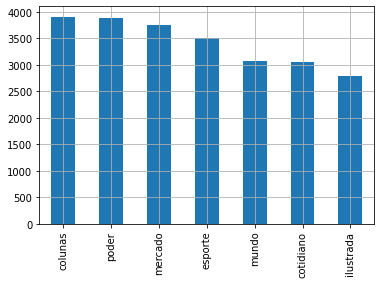

In [53]:
sample.category.value_counts().plot(kind='bar', grid=True)

### Obtendo TF-IDF das palavras.

In [ ]:
tf = TfidfVectorizer(min_df=3)
_ = tf.fit_transform(df.text_clean)

In [ ]:
def get_tfidf_norm(sent, cbow_model, tfidf):
    x = np.array([ tfidf.idf_[tfidf.vocabulary_[token]] for token in sent if token in tfidf.vocabulary_ and token in cbow_model.wv ])
    x = x / np.max(x)
    return x
if EVALUATE_TFIDF_WEIGHTS:
    tfidf_matrix = np.array([ get_tfidf_norm(sent, cbow_model, tf) for sent in tqdm(sample.sent_tokens.values) ])
    np.save("embeddings/tfidf_scores.npy", tfidf_matrix, allow_pickle=True)
else:
    tfidf_matrix = np.load("embeddings/tfidf_scores.npy", allow_pickle=True)

## Representações vetoriais.
Neste trabalho o nosso objetivo é investigar estratégias para produção de embeddings ricos em contexto, com menor custo computacional. Com inspiração nas camadas de self-attention utilizadas em arquiteturas Transformers, neste trabalho investigaremos a aplicação de self-attention em embeddings Fasttext. Nosso objetivo é, produzir para cada palavra em um documento qualquer em nosso corpus, embeddings contextualizados de cada palavra de modo a “saturar” a contextualização do embedding do documento através da média dos embeddings das palavras que o constitue. Com esta estratégia esperamos “amplificar” a informação contextual no embedding dos documentos. Desta maneira consideramos duas abordagens de self-attention, scaled product self-attention (SP-SA) e cosine self-attention. 
SP-SA é uma das formas de se calcular self-attention e é utilizada em modelos como Transformers e BERT. Para enriquecer os embeddings de palavras de um documento $W$ com o contexto formado por palavras vizinhas estima-se o “score” de importância entre os para todo par de palavra $wi, wj \in W$ através do produto escalar entre os embeddings que as representam. Logo, temos o score entre duas palavras definido como:

$score(w_i, w_j) = e_i \times e_j$

Sendo a matriz $A$ com os scores de atenção, definida como: 

$A^{W \times W}, \quad A_{ij} = score(w_i,w_j)$

Após a construção de A, normalizamos os scores com aplicando a função softmax:

$Att = softmax(A), \quad Att^{W \times W}$

Após obter a matriz $Att$ contextualizamos os vetores das palavras multiplicando os embeddings E do documento $W$, pela matriz $Att$, resultando na matrix $C$.

$C^{W \times d}, \quad C = E^{T} \cdot Att, \quad E^{W \times d}$, sendo $d$ a dimensão dos vetores densos Fasttext.

Cada vetor $ci$ de $C$, consiste no vetor contextualizado da palavra $wi$. O vetor resultante do documento é dado como a média de $C$.
De forma similar, para atenção com base na similaridade de cosseno, apenas alteramos a função de score que agora é definida como se segue:

$score(w_i,w_j) = cosseno(e_i,e_j)$

Além da aplicação de atenção, analisamos também o impacto da adição de posição (Vaswani et. al., 2017). A informação da posição é codificada através da codificação da variação das frequências definidas em $f(t)$. Para cada palavra $t$ é produzido um vetor $\overrightarrow{P}$, tal que $\overrightarrow{P}_t \in \mathbb{R}^{d}$. Para cada dimensão $d_i$ de $dim(\overrightarrow{P}_t)$ é atribuído o valor de seno (caso $i$ par) e cosseno (caso $i$ impar). O cálculo das frequências leva em consideração o parâmetro $t$ que é referente a posição da palavra no texto, alterando assim as frequências e por consequente o vetor de posição das palavras. Desta forma, uma palavra que aparece mais de uma vez em um documento, terá ainda sim, informação de posição diferente para cada aparição. A codificação da posição é definida matematicamente como se segue:

$
\overrightarrow{P}^{(i)}_t = f(t)^{(i)} = \left\{\begin{matrix}
sin(w_k \cdot t), & if i = 2k\\ 
cos(w_k \cdot t), & if i = 2k + 1
\end{matrix}\right.,  \quad w_k = \frac{1}{10000^{\frac{2k}{d}}}$

In [ ]:
def get_positional_embs(n_words=10000, dim=200):

    return np.vstack([positional_vector(i, dim=dim) for i in range(n_words)])


def positional_vector(pos, dim=100, denom=10000):

    pos_values = []
    for i in range(dim):
        pw = 2 * i
        if i % 2 == 0:
            res = np.sin(pos / np.power(denom, pw/dim))
        else:
            res = np.cos(pos / np.power(denom, pw/dim))
        pos_values.append(res)
    return np.array(pos_values)


def check_word(word, cbow_model, skip_model, tf=None):

    # Se a palavra estiver no cbow e no skipgram.
    if word in cbow_model.wv and word in skip_model.wv:
        # Se não estiver usando IDF.
        if tf is None:
            return True
        else:
            # Se a palavra estiver no vocabulário IDF.
            if word in tf.vocabulary_:
                return True
    return False


def tokens_to_embs(sent_tokens, cbow, skip, option=1, pos_embs=None, idf=None, tf=None):

    if option not in [1, 2, 3]:
        option = 2

    # Cbow somente
    if option == 1:
        words_vec = np.vstack([cbow.wv[token] for token in sent_tokens if check_word(
            token, cbow_model, skip_model, tf)])
    # Skip Gram
    elif option == 2:
        words_vec = np.vstack([cbow.wv[token] for token in sent_tokens if check_word(
            token, cbow_model, skip_model, tf)])
    # Skip e Cbow Combinados.
    elif option == 3:
        words_vec = np.vstack([np.hstack([cbow.wv[token], skip.wv[token]])
                              for token in sent_tokens if check_word(token, cbow_model, skip_model, tf)])

    if pos_embs is not None:
        words_vec += pos_embs[:words_vec.shape[0], :words_vec.shape[1]]
        return words_vec
    if idf is not None:
        return (words_vec.T * idf).T
    return words_vec


def get_raw_embs(sentences_tokes, cbow, skip, option=1, pos_embs=None, tfidf_matrix=None, tf=None):

    if tfidf_matrix is None:
        return np.vstack([np.mean(tokens_to_embs(sent_tokens, cbow, skip, option=option, pos_embs=pos_embs, tf=tf), axis=0) for sent_tokens in sentences_tokes])
    else:
        return np.vstack([np.mean(tokens_to_embs(sent_tokens, cbow, skip, option=option, pos_embs=pos_embs, idf=widf, tf=tf), axis=0) for sent_tokens, widf in zip(sentences_tokes, tfidf_matrix)])


def attention_eval(embs, norm="mean", att_type="product"):

    if att_type == "product":
        w = softmax(np.inner(embs, embs)/np.sqrt(embs.shape[1]), axis=0)
    else:
        w = softmax(cosine_similarity(embs, embs), axis=0)

    context_words = np.dot(w, embs)

    if norm == "mean":
        att = np.mean(context_words, axis=0)
        return att
    else:
        att = softmax(np.sum(context_words, axis=0), axis=0)
        return att


def attention(sentences_tokes, cbow, skip, option=1, norm="mean", pos_embs=None, tfidf_matrix=None, tf=None, att_type="product"):

    if tfidf_matrix is None:
        return np.array([attention_eval(tokens_to_embs(sent_tokens, cbow, skip, option=option, pos_embs=pos_embs, tf=tf), att_type=att_type) for sent_tokens in sentences_tokes])
    else:
        return np.array([attention_eval(tokens_to_embs(sent_tokens, cbow, skip, option=option, pos_embs=pos_embs, idf=widf, tf=tf), att_type=att_type) for sent_tokens, widf in zip(sentences_tokes, tfidf_matrix)])


def save_embs(dict_embs, embs_dir):

    for emb in dict_embs:
        np.save(f"{embs_dir}/{emb}.npy", dict_embs[emb], allow_pickle=True)


## Cross-Validation pipeline
Para avaliar as representações de atenção, utilizaremos validação cruzada com 5 folds. Para avaliar o modelo, utilizamos as seguintes métricas: 

$precision = \frac{TP_t}{TP_t + FP_t}$

$recall = \frac{TP_t}{TP_t + FN_t}$

$MicroF1 = \frac{2 \cdot precision \cdot  recall}{precision + recall}$

$MacroF1 = \frac{1}{|T|} \cdot \sum_{t \in T} \frac{2 \cdot precision \cdot  recall}{precision + recall}$

Visto que nosso objetivo é avaliar as representações vetoriais utilizaremos o classificador Regressão Logística. Este classificador é conhecido principalmente pela sua velocidade de treino, estabilidade e confiança, sendo ideal para nosso cenário, onde vários experimentos são feitos com validação cruzada.


In [32]:
def evaluate(dict_embs, y_true, dict_scores, kf):

    for key_emb in dict_embs:
        print(f"Embedding: {key_emb}")
        dict_scores[key_emb] = {}
        fold = 0
        # Para cada fold.
        for train_idx, test_idx in kf.split(dict_embs[key_emb], y_true):
            print(f"\tFold: {fold}")
            # Para cada classificador.    
            logistic = LogisticRegression(max_iter=5000, n_jobs=10)
            logistic.fit(dict_embs[key_emb][train_idx], y_true[train_idx])
            y_pred = logistic.predict(dict_embs[key_emb][test_idx])
            # Calculando métricas.
            if "micro" not in dict_scores[key_emb]:
                dict_scores[key_emb]["micro"] = []
            dict_scores[key_emb]["micro"].append(f1_score(y_true[test_idx], y_pred, average="micro"))
            if "macro" not in dict_scores[key_emb]:
                dict_scores[key_emb]["macro"] = []
            dict_scores[key_emb]["macro"].append(f1_score(y_true[test_idx], y_pred, average="macro"))
            if "precision" not in dict_scores[key_emb]:
                dict_scores[key_emb]["precision"] = []
            dict_scores[key_emb]["precision"].append(precision_score(y_true[test_idx], y_pred, average="macro", zero_division=0))
            if "recall" not in dict_scores[key_emb]:
                dict_scores[key_emb]["recall"] = []
            dict_scores[key_emb]["recall"].append(recall_score(y_true[test_idx], y_pred, average="macro"))
            if "y_pred" not in dict_scores[key_emb]:
                dict_scores[key_emb]["y_pred"] = {}
            dict_scores[key_emb]["y_pred"][fold] = y_pred.tolist()
            fold += 1

## Generating Baseline Embeddings

In [41]:
dict_embs = {}
if MAKE_EMBEDDINGS:
    dict_embs["cbow"] = get_raw_embs(sample.sent_tokens.values[:SIZE], cbow_model, skip_model, option=1)
    print("cbow: Done.")
    dict_embs["skip"] = get_raw_embs(sample.sent_tokens.values[:SIZE], cbow_model, skip_model, option=2)
    print("skip: Done.")
    dict_embs["cbow_skip"] = get_raw_embs(sample.sent_tokens.values[:SIZE], cbow_model, skip_model, option=3)
    print("cbow_skip: Done.")
    dict_embs["cbow-tf-idf"] = get_raw_embs(sample.sent_tokens.values[:SIZE], cbow_model, skip_model, option=1, tfidf_matrix=tfidf_matrix, tf=tf)
    print("cbow-tf-idf: Done.")
    dict_embs["skip-tf-idf"] = get_raw_embs(sample.sent_tokens.values[:SIZE], cbow_model, skip_model, option=2, tfidf_matrix=tfidf_matrix, tf=tf)
    print("skip-tf-idf: Done.")
    dict_embs["cbow_skip-tf-idf"] = get_raw_embs(sample.sent_tokens.values[:SIZE], cbow_model, skip_model, option=3, tfidf_matrix=tfidf_matrix, tf=tf)
    print("cbow_skip-tf-idf: Done.")
    save_embs(dict_embs, "embeddings")
else:
    dict_embs["cbow"] = np.load("embeddings/cbow.npy")
    dict_embs["skip"] = np.load("embeddings/skip.npy")
    dict_embs["cbow_skip"] = np.load("embeddings/cbow_skip.npy")
    dict_embs["cbow-tf-idf"] = np.load("embeddings/cbow-tf-idf.npy")
    dict_embs["skip-tf-idf"] = np.load("embeddings/skip-tf-idf.npy")
    dict_embs["cbow_skip-tf-idf"] = np.load("embeddings/cbow_skip-tf-idf.npy")

cbow: Done.
skip: Done.
cbow_skip: Done.
cbow-tf-idf: Done.
skip-tf-idf: Done.
cbow_skip-tf-idf: Done.


# Avaliação das baselines

Neste trabalho utilizaremos como baseline para as avaliações aqui feitas as seguintes representações: Fasttext-Cbow, Fasttext-Skip-Gram e Cbow-Skip-Gram (concatenação dos vetores duas estratégias).

* cbow - Representações Cbow (Fasttext) sem alteraçães.
* skip - Representações Skip-Gram (Fasttext) sem alteraçães.
* cbow_skip - Combinação (Concatenação) do Skip-Gram com o Cbow.
* cbow-tf-idf - Ponderação do embedding Cbow com o valor de TF-IDF da palavra.
* skip-tf-idf - Ponderação do embedding Skip-Gram com o valor de TF-IDF da palavra.
* cbow_skip-tf-idf - Ponderação da combinação Cbow-Skip com o valor de TF-IDF da palavra.

In [33]:
dict_scores = {}
le = preprocessing.LabelEncoder()
le.fit(sample.category.values[:SIZE])
y_true = le.transform(sample.category.values[:SIZE])
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [38]:
evaluate(dict_embs, y_true, dict_scores, kf)

Embedding: cbow
	Fold: 0
	Fold: 1
	Fold: 2
	Fold: 3
	Fold: 4
Embedding: skip
	Fold: 0
	Fold: 1
	Fold: 2
	Fold: 3
	Fold: 4
Embedding: cbow_skip
	Fold: 0
	Fold: 1
	Fold: 2
	Fold: 3
	Fold: 4
Embedding: cbow-tf-idf
	Fold: 0
	Fold: 1
	Fold: 2
	Fold: 3
	Fold: 4
Embedding: skip-tf-idf
	Fold: 0
	Fold: 1
	Fold: 2
	Fold: 3
	Fold: 4
Embedding: cbow_skip-tf-idf
	Fold: 0
	Fold: 1
	Fold: 2
	Fold: 3
	Fold: 4


In [40]:
if LOAD_SCORES:
    with open("outputs/scores.json", 'r') as fd:
        dict_scores = json.load(fd)

show_results(dict_scores, pattern="positional|cosine|product")

,Embedding,Precision,Std Precision,Recall,Std Recall,Micro,Std Micro,Macro,Std Macro
2,cbow_skip,83.92,0.002951,84.24,0.002234,83.76,0.002540,84.05,0.002564
5,cbow_skip-tf-idf,83.54,0.002989,83.97,0.003698,83.44,0.003544,83.71,0.003160
3,cbow-tf-idf,83.11,0.003136,83.54,0.003820,83.00,0.003366,83.28,0.003314
4,skip-tf-idf,83.11,0.003136,83.54,0.003820,83.00,0.003366,83.28,0.003314
0,cbow,83.09,0.003158,83.43,0.003236,82.93,0.002952,83.23,0.003043
1,skip,83.09,0.003158,83.43,0.003236,82.93,0.002952,83.23,0.003043


### Desempenho baselines
As baselines possuem resultados bem próximos entre si, com menos de 1% de diferença em Macro-F1 entre a melhor (cbow_skip) e pior representação (skip). As representações com cbow e skip gram se saíram ligeiramente melhor conforme esperado, uma vez que ambos modelos Cbow e Skip-Gram capturam informações diferentes, logo a combinação entre Cbow e Skip-Gram traz consigo um conjunto mais diverso de informação.



## Variantes com Atenção (Self-Attention)

* cbow_skip-product - Embeddings Cbow-Skip contextualizados com Scaled-Product-Attention.
* cbow_skip-product-positional - Embeddings Cbow-Skip contextualizados com Scaled-Product-Attention mais informação de posição da palavra.
* cbow_skip-tf-idf-product - Embeddings Cbow-Skip contextualizados com Scaled-Product-Attention mais ponderamento com TF-IDF.
* cbow_skip-tf-idf-product-positional - Embeddings Cbow-Skip contextualizados com Scaled-Product-Attention mais ponderamento do TF-IDF e informação de posição da palavra.
* cbow_skip-cosine - Embeddings Cbow-Skip contextualizados com Cosine-Attention.
* cbow_skip-cosine-positional - Embeddings Cbow-Skip contextualizados com Cosine-Attention mais informação de posição da palavra.
* cbow_skip-tf-idf-cosine - Embeddings Cbow-Skip contextualizados com Cosine-Attention mais ponderamento com TF-IDF.
* cbow_skip-tf-idf-cosine-positional - Embeddings Cbow-Skip contextualizados com Cosine-Attention mais ponderamento do TF-IDF e informação de posição da palavra.

In [ ]:
pos_embs = get_positional_embs()

In [21]:
dict_embs = {}
if MAKE_EMBEDDINGS:
    # Product Attention.
    dict_embs["cbow_skip-product"] = attention(sample.sent_tokens.values[:SIZE], cbow_model, skip_model, option=3)
    print("cbow_skip-product: Done.")
    dict_embs["cbow_skip-product-positional"] = attention(sample.sent_tokens.values[:SIZE], cbow_model, skip_model, option=3)
    print("cbow_skip-product-positional: Done.")
    dict_embs["cbow_skip-tf-idf-product"] = attention(sample.sent_tokens.values[:SIZE], cbow_model, skip_model, option=3, tfidf_matrix=tfidf_matrix, tf=tf)
    print("cbow_skip-tf-idf-product: Done.")
    dict_embs["cbow_skip-tf-idf-product-positional"] = attention(sample.sent_tokens.values[:SIZE], cbow_model, skip_model, option=3, pos_embs=pos_embs, tfidf_matrix=tfidf_matrix, tf=tf)
    print("cbow_skip-tf-idf-product-positional: Done.")
    # Consine Attention
    dict_embs["cbow_skip-cosine"] = attention(sample.sent_tokens.values[:SIZE], cbow_model, skip_model, option=3, att_type="cosine")
    print("cbow_skip-cosine: Done.")
    dict_embs["cbow_skip-cosine-positional"] = attention(sample.sent_tokens.values[:SIZE], cbow_model, skip_model, option=3, att_type="cosine")
    print("cbow_skip-cosine-positional: Done.")
    dict_embs["cbow_skip-tf-idf-cosine"] = attention(sample.sent_tokens.values[:SIZE], cbow_model, skip_model, option=3, tfidf_matrix=tfidf_matrix, att_type="cosine", tf=tf)
    print("cbow_skip-tf-idf-cosine: Done.")
    dict_embs["cbow_skip-tf-idf-cosine-positional"] = attention(sample.sent_tokens.values[:SIZE], cbow_model, skip_model, option=3, pos_embs=pos_embs, tfidf_matrix=tfidf_matrix, att_type="cosine", tf=tf)
    print("cbow_skip-tf-idf-cosine-positional: Done.")
    save_embs(dict_embs, "embeddings")
else:
    # Product Attention
    dict_embs["cbow_skip-product"] = np.load("embeddings/cbow_skip-product.npy")
    dict_embs["cbow_skip-product-positional"] = np.load("embeddings/cbow_skip-product-positional.npy")
    dict_embs["cbow_skip-tf-idf-product"] = np.load("embeddings/cbow_skip-tf-idf-product.npy")
    dict_embs["cbow_skip-tf-idf-product-positional"] = np.load("embeddings/cbow_skip-tf-idf-product-positional.npy")
    # Cosine Attention
    dict_embs["cbow_skip-cosine"] = np.load("embeddings/cbow_skip-cosine.npy")
    dict_embs["cbow_skip-cosine-positional"] = np.load("embeddings/cbow_skip-cosine-positional.npy")
    dict_embs["cbow_skip-tf-idf-cosine"] = np.load("embeddings/cbow_skip-tf-idf-cosine.npy")
    dict_embs["cbow_skip-tf-idf-cosine-positional"] = np.load("embeddings/cbow_skip-tf-idf-cosine-positional.npy")

cbow_skip-product: Done.
cbow_skip-product-positional: Done.
cbow_skip-tf-idf-product: Done.
cbow_skip-tf-idf-product-positional: Done.
cbow_skip-consise: Done.
cbow_skip-consise-positional: Done.
cbow_skip-tf-idf-consise: Done.
cbow_skip-tf-idf-consise-positional: Done.


### Cross-Validation

In [34]:
evaluate(dict_embs, y_true, dict_scores, kf)

Embedding: cbow_skip-product
	Fold: 0
	Fold: 1
	Fold: 2
	Fold: 3
	Fold: 4
Embedding: cbow_skip-product-positional
	Fold: 0
	Fold: 1
	Fold: 2
	Fold: 3
	Fold: 4
Embedding: cbow_skip-tf-idf-product
	Fold: 0
	Fold: 1
	Fold: 2
	Fold: 3
	Fold: 4
Embedding: cbow_skip-tf-idf-product-positional
	Fold: 0
	Fold: 1
	Fold: 2
	Fold: 3
	Fold: 4
Embedding: cbow_skip-consise
	Fold: 0
	Fold: 1
	Fold: 2
	Fold: 3
	Fold: 4
Embedding: cbow_skip-consise-positional
	Fold: 0
	Fold: 1
	Fold: 2
	Fold: 3
	Fold: 4
Embedding: cbow_skip-tf-idf-consise
	Fold: 0
	Fold: 1
	Fold: 2
	Fold: 3
	Fold: 4
Embedding: cbow_skip-tf-idf-consise-positional
	Fold: 0
	Fold: 1
	Fold: 2
	Fold: 3
	Fold: 4


In [42]:
if LOAD_SCORES:
    with open("outputs/scores.json", 'r') as fd:
        dict_scores = json.load(fd)

show_results(dict_scores, pattern="positional")

,Embedding,Precision,Std Precision,Recall,Std Recall,Micro,Std Micro,Macro,Std Macro
10,cbow_skip-cosine,83.93,0.002864,84.25,0.002213,83.77,0.002427,84.06,0.002500
2,cbow_skip,83.92,0.002951,84.24,0.002234,83.76,0.002540,84.05,0.002564
6,cbow_skip-product,83.92,0.003059,84.25,0.002405,83.77,0.002616,84.05,0.002696
5,cbow_skip-tf-idf,83.54,0.002989,83.97,0.003698,83.44,0.003544,83.71,0.003160
8,cbow_skip-tf-idf-product,83.53,0.003039,83.97,0.003744,83.43,0.003578,83.71,0.003206
12,cbow_skip-tf-idf-cosine,83.54,0.003010,83.97,0.003720,83.43,0.003560,83.71,0.003181
3,cbow-tf-idf,83.11,0.003136,83.54,0.003820,83.00,0.003366,83.28,0.003314
4,skip-tf-idf,83.11,0.003136,83.54,0.003820,83.00,0.003366,83.28,0.003314
0,cbow,83.09,0.003158,83.43,0.003236,82.93,0.002952,83.23,0.003043
1,skip,83.09,0.003158,83.43,0.003236,82.93,0.002952,83.23,0.003043


## Variantes com Positional Encoding

* cbow_positional - Representações Cbow com mais a adição de informação de posição.
* skip_positional - Representações Skip-Gram com mais a adição de informação de posição.
* cbow_skip_positional - Combinação das representações Cbow e Skip-Gram com mais a adição de informação de posição.

In [42]:
dict_embs = {}
if MAKE_EMBEDDINGS:
    dict_embs["cbow_positional"] = get_raw_embs(sample.sent_tokens.values[:SIZE], cbow_model, skip_model, option=1, pos_embs=pos_embs, tfidf_matrix=tfidf_matrix)
    print("cbow_positional: Done.")
    dict_embs["skip_positional"] = get_raw_embs(sample.sent_tokens.values[:SIZE], cbow_model, skip_model, option=2, pos_embs=pos_embs, tfidf_matrix=tfidf_matrix)
    print("skip_positional: Done.")
    dict_embs["cbow_skip_positional"] = get_raw_embs(sample.sent_tokens.values[:SIZE], cbow_model, skip_model, option=3, pos_embs=pos_embs, tfidf_matrix=tfidf_matrix)
    print("cbow_skip_positional: Done.")
    save_embs(dict_embs, "embeddings")

cbow_positional: Done.
skip_positional: Done.
cbow_skip_positional: Done.


### Cross-Validation

In [43]:
evaluate(dict_embs, y_true, dict_scores, kf)

Embedding: cbow_positional
	Fold: 0
	Fold: 1
	Fold: 2
	Fold: 3
	Fold: 4
Embedding: skip_positional
	Fold: 0
	Fold: 1
	Fold: 2
	Fold: 3
	Fold: 4
Embedding: cbow_skip_positional
	Fold: 0
	Fold: 1
	Fold: 2
	Fold: 3
	Fold: 4


In [44]:
if LOAD_SCORES:
    with open("outputs/scores.json", 'r') as fd:
        dict_scores = json.load(fd)

show_results(dict_scores, pattern="cosine|product")

,Embedding,Precision,Std Precision,Recall,Std Recall,Micro,Std Micro,Macro,Std Macro
16,cbow_skip_positional,84.18,0.002251,84.48,0.002693,84.02,0.002208,84.30,0.002306
2,cbow_skip,83.92,0.002951,84.24,0.002234,83.76,0.002540,84.05,0.002564
5,cbow_skip-tf-idf,83.54,0.002989,83.97,0.003698,83.44,0.003544,83.71,0.003160
3,cbow-tf-idf,83.11,0.003136,83.54,0.003820,83.00,0.003366,83.28,0.003314
4,skip-tf-idf,83.11,0.003136,83.54,0.003820,83.00,0.003366,83.28,0.003314
0,cbow,83.09,0.003158,83.43,0.003236,82.93,0.002952,83.23,0.003043
1,skip,83.09,0.003158,83.43,0.003236,82.93,0.002952,83.23,0.003043
14,cbow_positional,83.07,0.001461,83.42,0.002181,82.93,0.001666,83.21,0.001586
15,skip_positional,83.07,0.001461,83.42,0.002181,82.93,0.001666,83.21,0.001586


## Discusão geral

In [45]:
if LOAD_SCORES:
    with open("outputs/scores.json", 'r') as fd:
        dict_scores = json.load(fd)

show_results(dict_scores)

,Embedding,Precision,Std Precision,Recall,Std Recall,Micro,Std Micro,Macro,Std Macro
16,cbow_skip_positional,84.18,0.002251,84.48,0.002693,84.02,0.002208,84.30,0.002306
9,cbow_skip-tf-idf-product-positional,84.15,0.003577,84.47,0.003615,83.99,0.003324,84.28,0.003494
13,cbow_skip-tf-idf-cosine-positional,84.15,0.003582,84.47,0.003614,84.00,0.003330,84.28,0.003497
11,cbow_skip-cosine-positional,83.93,0.002864,84.25,0.002213,83.77,0.002427,84.06,0.002500
10,cbow_skip-cosine,83.93,0.002864,84.25,0.002213,83.77,0.002427,84.06,0.002500
2,cbow_skip,83.92,0.002951,84.24,0.002234,83.76,0.002540,84.05,0.002564
6,cbow_skip-product,83.92,0.003059,84.25,0.002405,83.77,0.002616,84.05,0.002696
7,cbow_skip-product-positional,83.92,0.003059,84.25,0.002405,83.77,0.002616,84.05,0.002696
12,cbow_skip-tf-idf-cosine,83.54,0.003010,83.97,0.003720,83.43,0.003560,83.71,0.003181
8,cbow_skip-tf-idf-product,83.53,0.003039,83.97,0.003744,83.43,0.003578,83.71,0.003206


In [ ]:
with open("outputs/scores.json","w") as fd:
    json.dump(dict_scores, fd)